In [ ]:
%%capture
!pip install datasets

In [ ]:
# The value for the seed
SEED = 168

In [ ]:
# Standard library imports
from collections import Counter

# General third-party libraries import
import copy
from gensim.models import KeyedVectors
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import sys

# Import pytorch
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn.utils.rnn import pad_sequence

# Import Transformers
import transformers
from transformers import (
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)

In [ ]:
# Method to set random seed to ensure consistency
def set_seed(seed = SEED):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    transformers.set_seed(seed)

# Factory to create the dataloader
def dataloader_factory(X_train_sequence, X_val_sequence, X_test_sequence, Y_train, Y_val, Y_test, batch_size, device):
    # Create Tensor datasets
    train_dataset = TensorDataset(X_train_sequence.to(device), torch.tensor(Y_train, dtype=torch.long, device=device))
    val_dataset = TensorDataset(X_val_sequence.to(device), torch.tensor(Y_val, dtype=torch.long, device=device))
    test_dataset = TensorDataset(X_test_sequence.to(device), torch.tensor(Y_test, dtype=torch.long, device=device))

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

# Early Stopper
class EarlyStopper:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > self.max_validation_accuracy:
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        elif validation_accuracy < (self.max_validation_accuracy - self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Factory to provide required optimizer which specified parameters
def optimizer_factory(optimizer_name, model, learning_rate, momentum = 0.8):
    if optimizer_name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr = learning_rate)
    if optimizer_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)
    if optimizer_name == 'RMSprop':
        return torch.optim.RMSprop(model.parameters(), lr = learning_rate)

# Method to train the model
def train_loop(dataloader, model, loss_fn, optimizer, scheduler, device):
    model.train()  # Set model to training mode
    train_loss = 0  # To accumulate loss for this epoch
    for data in dataloader:
        inputs, labels, input_ids, attention_mask = data["inputs"], data["labels"].to(device), data["input_ids"].to(device), data["attention_mask"].to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(input_ids, attention_mask)  # Forward pass

        # Calculate loss
        loss = loss_fn(outputs.squeeze(), labels.float())  # Squeeze to match dimensions
        loss.backward()  # Backpropagation

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()  # Update parameters
        scheduler.step() # Update scheduler

        train_loss += loss.item()  # Accumulate loss

    # Calculate average loss for the epoch
    train_loss /= len(dataloader)
    return train_loss

# Method to evaluate the model
def test_loop(dataloader, model, device):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for data in dataloader:
            inputs, labels, input_ids, attention_mask = data["inputs"], data["labels"].to(device), data["input_ids"].to(device), data["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask)  # Forward pass
            predicted = (outputs.squeeze() > 0.5).float()  # Apply threshold

            total += labels.size(0)
            correct += (predicted == labels.float()).sum().item()  # Count correct predictions

    accuracy = correct / total
    return accuracy

# Method to plot the performance graph
def plot_performance(train_losses, val_accuracies, num_epochs):
    # Visualization
    plt.figure(figsize=(12, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs + 1, 10))
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, num_epochs + 1, 10))
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Dataset Preparation**

In [ ]:
set_seed()
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [ ]:
print(f"train_dataset size: {len(train_dataset)}")
print(f"validation_dataset size: {len(validation_dataset)}")
print(f"test_dataset size: {len(test_dataset)}")
print(f"data format: {train_dataset[0]}")

train_dataset size: 8530
validation_dataset size: 1066
test_dataset size: 1066
data format: {'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}


In [ ]:
class MovieDataset(Dataset):
    def __init__(self, inputs, labels, tokenizer, max_len, device):
        self.inputs = inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        input = self.inputs[item]
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            input,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "inputs": input,
            "labels": torch.tensor(label, dtype=torch.long),
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

In [ ]:
# Factory to create the dataloader using custom dataset
def custom_dataloader_factory(train_df, validation_df, test_df, batch_size, device, tokenizer, max_len):
    # Create Tensor datasets
    train_dataset = MovieDataset(train_df['text'], train_df['label'], tokenizer, max_len, device)
    val_dataset = MovieDataset(validation_df['text'], validation_df['label'], tokenizer, max_len, device)
    test_dataset = MovieDataset(test_df['text'], test_df['label'], tokenizer, max_len, device)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [ ]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"The name of the CUDA device is: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!
The name of the CUDA device is: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
# Check if FlashAttention is available
print("FlashAttention available:", torch.backends.cuda.flash_sdp_enabled())

FlashAttention available: True


# **BERT - bert-base-cased**

In [ ]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
class BERTBaseCased(nn.Module):
    def __init__(self):
        super(BERTBaseCased, self).__init__()
        #self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, attn_implementation="flash_attention_2")
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)  # Output size is 1 for binary classification

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        output1 = self.dropout(pooled_output) # Apply dropout
        output2 = self.fc(output1) # Final fully connected layer

        # Sigmoid activation for binary classification
        output3 = torch.sigmoid(output2)

        return output3

## **Train and Test**

In [ ]:
# The Best Hyperparameters
learning_rate = 3e-5  # Learning rate choices
batch_size = 128  # Batch size choices
num_epochs = 50  # num epoch choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = custom_dataloader_factory(train_dataset, validation_dataset, test_dataset, batch_size, device, tokenizer, 70)

# Initialize the model
model = BERTBaseCased()
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# Create a scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1, num_training_steps=len(train_loader) * num_epochs)
# Initialize Early Stopper
early_stopper = EarlyStopper()

In [ ]:
# Transfer Learning
stop_layer = 'bert.encoder.layer.6.attention.self.query.weight'
for name, param in model.named_parameters():
    if stop_layer in name: # stop layer
        print("Stop layer found")
        break
    param.requires_grad = False

Stop layer found


In [ ]:
# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model, device)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = copy.deepcopy(model)

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model, device)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

C:\Users\60178\anaconda3\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch [1/50], Train Loss: 0.4786, Validation Accuracy: 0.8386
Epoch [2/50], Train Loss: 0.3238, Validation Accuracy: 0.8508
Epoch [3/50], Train Loss: 0.2537, Validation Accuracy: 0.8574
Epoch [4/50], Train Loss: 0.1873, Validation Accuracy: 0.8546
Epoch [5/50], Train Loss: 0.1343, Validation Accuracy: 0.8574
Epoch [6/50], Train Loss: 0.0955, Validation Accuracy: 0.8612
Epoch [7/50], Train Loss: 0.0704, Validation Accuracy: 0.8583
Epoch [8/50], Train Loss: 0.0479, Validation Accuracy: 0.8630
Epoch [9/50], Train Loss: 0.0444, Validation Accuracy: 0.8602
Epoch [10/50], Train Loss: 0.0293, Validation Accuracy: 0.8649
Epoch [11/50], Train Loss: 0.0242, Validation Accuracy: 0.8583
Epoch [12/50], Train Loss: 0.0279, Validation Accuracy: 0.8565
Epoch [13/50], Train Loss: 0.0190, Validation Accuracy: 0.8612
Epoch [14/50], Train Loss: 0.0180, Validation Accuracy: 0.8630
Early stopping triggered!
Using Best Model, Test Accuracy: 0.8462


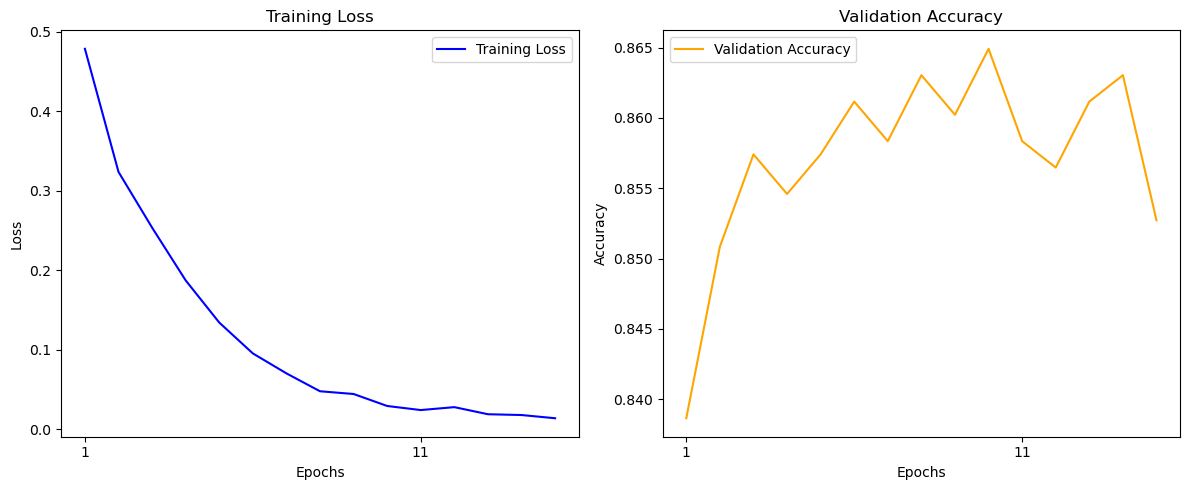

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))

# **BERT - RoBERTa**

In [ ]:
from transformers import (
    RobertaModel,
    RobertaTokenizer
)

In [ ]:
PRE_TRAINED_MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

C:\Users\60178\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
class BERTRoBERTa(nn.Module):
    def __init__(self):
        super(BERTRoBERTa, self).__init__()
        self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

        # Define Multi-Head Self-Attention (MHSA)
        #self.mhsa = nn.MultiheadAttention(embed_dim=self.bert.config.hidden_size, num_heads=12, batch_first=True)
        # Layer normalization for stability
        #self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)

        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)  # Output size is 1 for binary classification

    def forward(self, input_ids, attention_mask):
        #outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        #sequence_output = outputs.last_hidden_state

        # Multi-Head Self-Attention
        #attn_output, _ = self.mhsa(sequence_output, sequence_output, sequence_output)  # Self-attention
        #attn_output = self.layer_norm(attn_output + sequence_output)  # Residual connection and normalization

        # Use pooling to reduce to a single vector
        #pooled_output = torch.mean(attn_output, dim=1)  # Mean pooling across sequence length

        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        output1 = self.dropout(pooled_output) # Apply dropout
        output2 = self.fc(output1) # Final fully connected layer

        # Sigmoid activation for binary classification
        output3 = torch.sigmoid(output2)

        return output3

## **Train and Test**

In [ ]:
# The Best Hyperparameters
learning_rate = 1e-5  # Learning rate choices
batch_size = 128  # Batch size choices
num_epochs = 50  # num epoch choices

In [ ]:
# Reset the seed to ensure fairness when comparing performances
set_seed()

# Load Data
train_loader, val_loader, test_loader = custom_dataloader_factory(train_dataset, validation_dataset, test_dataset, batch_size, device, tokenizer, 75)

# Initialize the model
model = BERTRoBERTa()
model.to(device)
# Use BCELoss for binary classification
criterion = nn.BCELoss()
# Choose optimizer based on trial suggestion
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# Create a scheduler with warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=1, num_training_steps=len(train_loader) * num_epochs)
# Initialize Early Stopper
early_stopper = EarlyStopper()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Transfer Learning
stop_layer = 'bert.encoder.layer.9.attention.self.query.weight'
for name, param in model.named_parameters():
    if stop_layer in name: # stop layer
        print("Stop layer found")
        break
    param.requires_grad = False

Stop layer found


In [ ]:
# Lists to store loss and accuracy for visualization
train_losses = []
val_accuracies = []

# Training Loop
best_val_accuracy = 0
best_model = None
for epoch in range(num_epochs):
    # Train on train set
    train_loss = train_loop(train_loader, model, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_accuracy = test_loop(val_loader, model, device)
    val_accuracies.append(val_accuracy)

    # Get the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = copy.deepcopy(model)

    # Early stopping
    if early_stopper.early_stop(val_accuracy):
        print("Early stopping triggered!")
        break

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on test data
test_accuracy = test_loop(test_loader, best_model, device)

# Print out the performance
print(f"Using Best Model, Test Accuracy: {test_accuracy:.4f}")

Epoch [1/50], Train Loss: 0.6808, Validation Accuracy: 0.8180
Epoch [2/50], Train Loss: 0.3944, Validation Accuracy: 0.8677
Epoch [3/50], Train Loss: 0.3112, Validation Accuracy: 0.8743
Epoch [4/50], Train Loss: 0.2959, Validation Accuracy: 0.8809
Epoch [5/50], Train Loss: 0.2805, Validation Accuracy: 0.8818
Epoch [6/50], Train Loss: 0.2680, Validation Accuracy: 0.8865
Epoch [7/50], Train Loss: 0.2617, Validation Accuracy: 0.8818
Epoch [8/50], Train Loss: 0.2576, Validation Accuracy: 0.8893
Epoch [9/50], Train Loss: 0.2452, Validation Accuracy: 0.8893
Epoch [10/50], Train Loss: 0.2329, Validation Accuracy: 0.8902
Epoch [11/50], Train Loss: 0.2356, Validation Accuracy: 0.8865
Epoch [12/50], Train Loss: 0.2202, Validation Accuracy: 0.8912
Epoch [13/50], Train Loss: 0.2125, Validation Accuracy: 0.8884
Epoch [14/50], Train Loss: 0.2034, Validation Accuracy: 0.8837
Epoch [15/50], Train Loss: 0.1975, Validation Accuracy: 0.8865
Epoch [16/50], Train Loss: 0.1845, Validation Accuracy: 0.8818
E

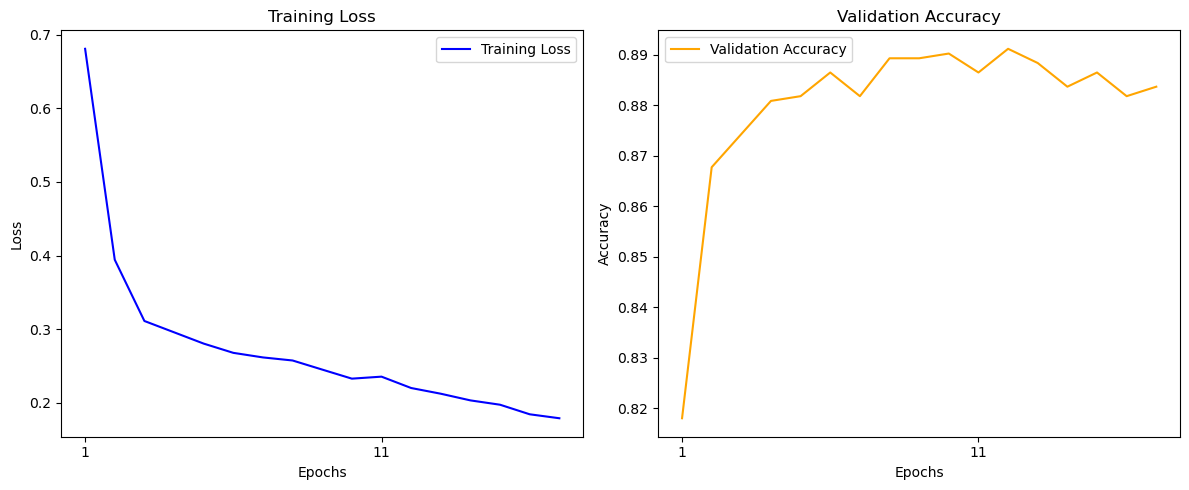

In [ ]:
plot_performance(train_losses, val_accuracies, len(train_losses))